In [11]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import MODEL
from model import architecture


from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Dense, Dropout, Flatten, Activation, Concatenate, Layer
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D, LSTM, CuDNNLSTM
import keras.backend as K

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

obj = MODEL()
arch_obj = architecture()

In [13]:
P = pd.read_csv('data/ProtSeqForModel.csv')
D = pd.read_csv('data/DrugSeqForModel.csv')
des_drug = np.load('data/DrugDesForModel.npy')
drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]

In [14]:
# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length = 1000
pad_target = pad_sequences(encode_target, maxlen=max_length, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length, padding='post', truncating='post')

# One hot encoding of sequences
# ohe_target = to_categorical(pad_target)
# ohe_drug = to_categorical(pad_drug)
# ohe_target.shape, ohe_drug.shape

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [15]:
# Define architecture
input_target, att_out_target = arch_obj.protSeq(1000)
input_drug, att_out_drug = arch_obj.drugSeq(1000)
input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

concat = Concatenate()([att_out_target,att_out_drug, dense_drug_des_2])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
dense_2 = Dense(256, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
dense_2_dropout = Dropout(0.2)(dense_2)
#dense_3 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_2)

x_output = Dense(3, activation='softmax')(dense_2_dropout)

# Bulid and compile model
model1 = Model(inputs=[input_target, input_drug, input_drug_des], outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1000, 128)    2688        input_4[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1000, 128)    5632        input_5[0][0]                    
____________________________________________________________________________________________

In [17]:
# Split indics into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(DTI_index)))
train_target, test_target, train_drug, test_drug, train_des, test_des, y_train, y_test = train_test_split(pad_target, pad_drug, des_drug, y, test_size=0.2, random_state=1)

print(train_target.shape, test_target.shape, train_drug.shape, test_drug.shape)

EXP = 'CD101T10'

# Early Stopping & checkpoint
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
filepath='checkpoints/'+EXP+'/improvement_'+'.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
histories = []

(49299, 1000) (12325, 1000) (49299, 1000) (12325, 1000)


In [18]:
history = model1.fit(
    [train_target, train_drug, train_des], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es, model_checkpoint]
    )

id not improve from 0.69644
Epoch 225/500
39439/39439 [==============================] - 19s 476us/step - loss: 0.6211 - accuracy: 0.7494 - val_loss: 0.7096 - val_accuracy: 0.7067

Epoch 00225: val_loss did not improve from 0.69644
Epoch 226/500
39439/39439 [==============================] - 19s 472us/step - loss: 0.6200 - accuracy: 0.7510 - val_loss: 0.7137 - val_accuracy: 0.7054

Epoch 00226: val_loss did not improve from 0.69644
Epoch 227/500
39439/39439 [==============================] - 19s 476us/step - loss: 0.6213 - accuracy: 0.7494 - val_loss: 0.7212 - val_accuracy: 0.7054

Epoch 00227: val_loss did not improve from 0.69644
Epoch 228/500
39439/39439 [==============================] - 19s 475us/step - loss: 0.6262 - accuracy: 0.7474 - val_loss: 0.7065 - val_accuracy: 0.7161

Epoch 00228: val_loss did not improve from 0.69644
Epoch 229/500
39439/39439 [==============================] - 19s 475us/step - loss: 0.6158 - accuracy: 0.7523 - val_loss: 0.7321 - val_accuracy: 0.7014

Epo

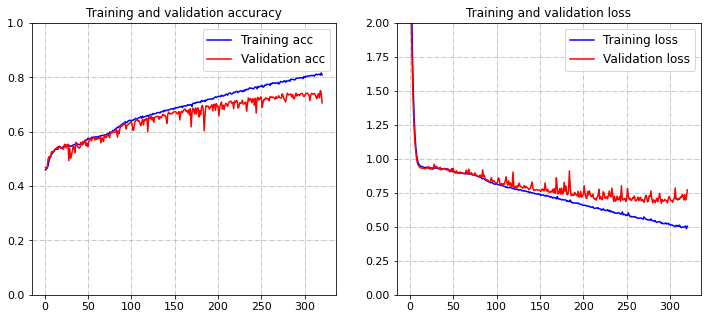

In [39]:
#  Training performance
fig, ax = plt.subplots(1,2,figsize=(12,5))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
x = range(1, len(acc) + 1)

ax[0].plot(x, acc, 'b', label='Training acc')
ax[0].plot(x, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].tick_params(axis="x", labelsize=11)
ax[0].tick_params(axis="y", labelsize=11)
ax[0].set_ylim([0,1])
ax[0].set_xticks(np.arange(0, 350, 50))
ax[0].legend(fontsize=12)
ax[0].grid(linestyle='-.', linewidth=0.7)

ax[1].plot(x, loss, 'b', label='Training loss')
ax[1].plot(x, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].tick_params(axis="x", labelsize=11)
ax[1].tick_params(axis="y", labelsize=11)
ax[1].set_ylim([0,2])
ax[1].set_xticks(np.arange(0, 350, 50))
ax[1].legend(fontsize=12)
ax[1].grid(linestyle='-.', linewidth=0.7)

In [40]:
# Compute ROC/AUC
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    y_pred_keras = model1.predict([test_target, test_drug, test_des])
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_keras[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# compute PR/AUPR
precision, recall, average_precision = dict(), dict(), dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_keras[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_keras[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred_keras.ravel())
average_precision["micro"] = average_precision_score(y_test, y_pred_keras, average="micro")
#print('Average precision score , micro-averaged over all classes: {0:0.2f}'
#    .format(average_precision["micro"]))

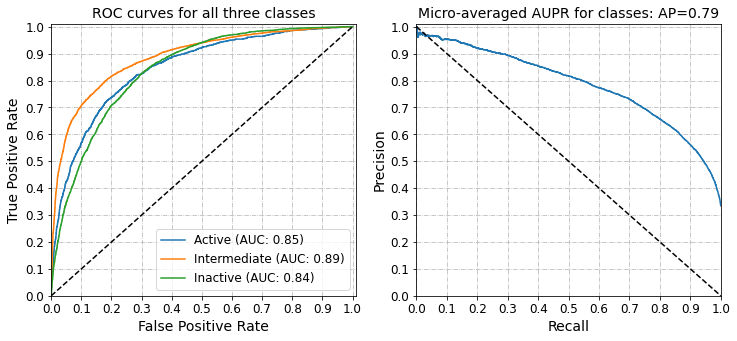

In [54]:
fig, ax = plt.subplots(1,2,figsize=(12,5))

for i, activity in zip(range(3),['Active', 'Intermediate','Inactive']):
    ax[0].plot(fpr[i], tpr[i], label=activity+' (AUC: %0.2f)' % roc_auc[i], alpha=1)
ax[0].plot([0, 1], [0, 1], 'k--')
ax[0].set_ylim([0.0, 1.01])
ax[0].set_xlim([0.0, 1.01])
ax[0].set_yticks(np.arange(0, 1.1, 0.1))
ax[0].set_xticks(np.arange(0, 1.1, 0.1))
ax[0].set_title('ROC curves for all three classes', fontsize=14)
ax[0].set_xlabel('False Positive Rate', fontsize=14)
ax[0].set_ylabel('True Positive Rate', fontsize=14)
#ax.set_title('Receiver operating characteristic ('+train_test+')', fontsize=14)
ax[0].tick_params(axis="x", labelsize=12)
ax[0].tick_params(axis="y", labelsize=12) 
ax[0].grid(linestyle='-.', linewidth=0.7)
ax[0].legend(fontsize=12)

ax[1].step(recall['micro'], precision['micro'], where='post')
ax[1].set_xlabel('Recall', fontsize=14)
ax[1].set_ylabel('Precision', fontsize=14)
ax[1].plot([0, 1], [1, 0], 'k--')
ax[1].set_ylim([0.0, 1.01])
ax[1].set_xlim([0.0, 1.00])
ax[1].set_yticks(np.arange(0, 1.1, 0.1))
ax[1].set_xticks(np.arange(0, 1.1, 0.1))
ax[1].set_title(
    'Micro-averaged AUPR for classes: AP={0:0.2f}'
    .format(average_precision["micro"]), fontsize=14)
ax[1].tick_params(axis="x", labelsize=12)
ax[1].tick_params(axis="y", labelsize=12) 
ax[1].grid(linestyle='-.', linewidth=0.7)


In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model1.evaluate([test_pad_target, test_pad_drug], y_test, batch_size=256)
print("test loss, test acc:", results)

In [ ]:
# EXTERNAL VALIDATIO